<a href="https://colab.research.google.com/github/abdullah-al-ryan/Sentiment-Analysis-on-Airline-Reviews/blob/main/Sentiment_Analysis_on_Airline_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import nltk

from nltk.tokenize import word_tokenize
import re

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense, Dropout, SpatialDropout1D
from keras.layers import Conv1D , GlobalMaxPooling1D,MaxPooling1D,Conv2D
from keras.callbacks import ModelCheckpoint

In [ ]:
num_classes = 3

embed_num_dims = 200
max_seq_len = 1000


class_names = ['Positive', 'Negative','Neutral']

In [ ]:
def shuffle(df, n=1, axis=0):
    df = df.copy()
    for _ in range(n):
      df.apply(np.random.shuffle, axis=axis)
    return df

In [ ]:
data= pd.read_excel('/content/air_rev_66.xlsx')

In [ ]:
print(data.columns)

Index(['Comment', 'Class'], dtype='object')


In [ ]:
data.isnull().values.any()

True

In [ ]:
data.dropna(subset = ["Comment","Class"], inplace =True )

In [ ]:
data.isnull().values.any()

False

<Axes: xlabel='Class', ylabel='count'>

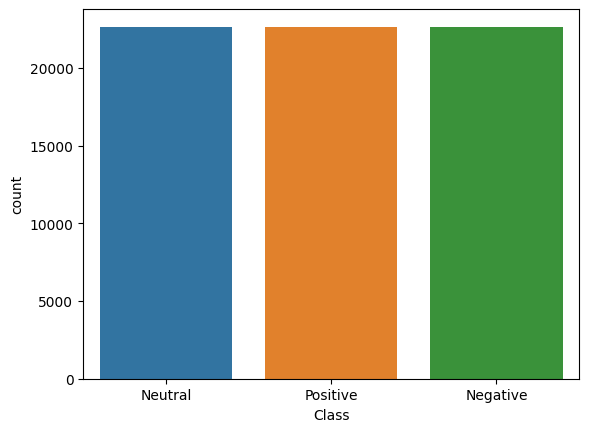

In [ ]:
import seaborn as sns
sns.countplot(x='Class', data=data)

In [ ]:
data.sort_values(by='Class', axis=0, inplace=True)

data.set_index(keys=['Class'], drop=False,inplace=True)
Categorys=data['Class'].unique().tolist()

In [ ]:
positives = shuffle(data.loc[data.Class=='Positive'])
negatives = shuffle(data.loc[data.Class=='Negative'])
neutrals = shuffle(data.loc[data.Class=='Neutral'])

/usr/local/lib/python3.10/dist-packages/pandas/core/apply.py:907: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  results[i] = self.f(v)
/usr/local/lib/python3.10/dist-packages/pandas/core/apply.py:907: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  results[i] = self.f(v)
/usr/local/lib/python3.10/dist-packages/pandas/core/apply.py:907: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  results[i] = self.f(v)


In [ ]:
positives_train = positives.iloc[0:int(positives.shape[0]*1)]
positives_test = positives.iloc[0:int(positives.shape[0]*1)]

negatives_train = negatives.iloc[0:int(negatives.shape[0]*1)]
negatives_test = negatives.iloc[0:int(negatives.shape[0]*1)]

neutrals_train = neutrals.iloc[0:int(neutrals.shape[0]*1)]
neutrals_test = neutrals.iloc[0:int(neutrals.shape[0]*1)]

data_train = pd.concat([positives_train, negatives_train, neutrals_train])
data_test = pd.concat([positives_test, negatives_test, neutrals_test])

print(data_train.shape)
print(data_test.shape)

(67922, 2)
(67922, 2)


In [ ]:
X_train = data_train.Comment
X_test = data_test.Comment

y_train = data_train.Class
y_test = data_test.Class

data = data_train.append(data_test, ignore_index=True)

print(data.Class.value_counts())
data.head(10)

Negative    45314
Neutral     45276
Positive    45254
Name: Class, dtype: int64


<ipython-input-50-b665112266b5>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data_train.append(data_test, ignore_index=True)


,Comment,Class
0,Great app,Positive
1,"Brilliant app. We'll done, BA!",Positive
2,Excellent,Positive
3,"I’ve had the AA app for years, but today I use...",Positive
4,"So far so good, I bought my ticket and paid fo...",Positive
5,I love this app. its exciting to look up my fu...,Positive
6,Great app,Positive
7,Extremely helpful,Positive
8,one word perfect application.,Positive
9,Easy to use and convenient,Positive


In [ ]:
print(data.dtypes)


Comment    object
Class      object
dtype: object


In [ ]:
print(data_train.Class.value_counts())
print(data_test.Class.value_counts())

Negative    22657
Neutral     22638
Positive    22627
Name: Class, dtype: int64
Negative    22657
Neutral     22638
Positive    22627
Name: Class, dtype: int64


In [ ]:
def clean_text(data):
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    data = word_tokenize(data)

    return data

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import re
from nltk.tokenize import word_tokenize
def remove_emojis(text):
    # Emoji pattern: Matches any unicode emoji
    emoji_pattern = re.compile("[\U0001F600-\U0001F64F]|[\U0001F300-\U0001F5FF]|[\U0001F680-\U0001F6FF]|[\U0001F1E0-\U0001F1FF]|[\U00002702-\U000027B0]|[\U000024C2-\U0001F251]", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def clean_text(data):
    # Check if data is None or NaN, and convert to an empty string
    if data is None or pd.isnull(data):
        data = ''

    # Convert data to string if it's not already
    if not isinstance(data, str):
        data = str(data)

    # Text cleaning operations
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    data = remove_emojis(data)
    data_tokens = word_tokenize(data)
    cleaned_data = ' '.join(data_tokens)

    return cleaned_data

texts = [clean_text(text) for text in data.Comment]
texts_train = [clean_text(text) for text in X_train]
texts_test = [clean_text(text) for text in X_test]

print(texts_train[50])

Nice


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 24205


In [ ]:
!pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.4 MB/s eta 0:00:00


In [ ]:
from keras_preprocessing.sequence import pad_sequences

In [ ]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[    0,     0,     0, ...,     0,    43,     4],
       [    0,     0,     0, ...,   502,   340,   185],
       [    0,     0,     0, ...,     0,     0,   123],
       ...,
       [    0,     0,     0, ...,   257,  2155,   705],
       [    0,     0,     0, ...,   534,   173,   385],
       [    0,     0,     0, ..., 24204, 11548, 24205]], dtype=int32)

In [ ]:
encoding = {
    'Positive': 0,
    'Negative': 1,
    'Neutral': 2
}

y_train = [encoding[x] for x in data_train.Class]
y_test = [encoding[x] for x in data_test.Class]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
GLOVE_DIM = 200

import urllib.request
import zipfile
import os

fname = 'glove.twitter.27B.' + str(GLOVE_DIM) + 'd.txt'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('http://nlp.stanford.edu/data/glove.twitter.27B.zip',
                              'glove.twitter.27B.zip')
    print('Unzipping...')
    with zipfile.ZipFile('glove.twitter.27B.zip', 'r') as zip_ref:
        zip_ref.extractall('')
    print('done.')

    os.remove('glove.twitter.27B.zip')

Unzipping...
done.


In [ ]:
glove_file = 'glove.twitter.27B.' + str(GLOVE_DIM) + 'd.txt'
emb_dict = {}
glove = open(glove_file)
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

NB_WORDS = vocab_size
MAX_LEN = max_seq_len

emb_matrix = np.zeros((NB_WORDS, GLOVE_DIM))
for w, i in tokenizer.word_index.items():
    if i < NB_WORDS:
        vect = emb_dict.get(w)
        if vect is not None:
          emb_matrix[i] = vect
    else:
        break

In [ ]:
embedd_layer = Embedding(vocab_size,
                         GLOVE_DIM,
                         input_length = max_seq_len,
                         weights = [emb_matrix],
                         trainable=False)

lstm_size = 128

In [ ]:
model = Sequential()
model.add(embedd_layer)

model.add(SpatialDropout1D(0.2))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(lstm_size, return_sequences = True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(lstm_size)))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 200)         4841200   
                                                                 
 spatial_dropout1d (SpatialD  (None, 1000, 200)        0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 1000, 32)          19232     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 500, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 32)           3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 250, 32)          0

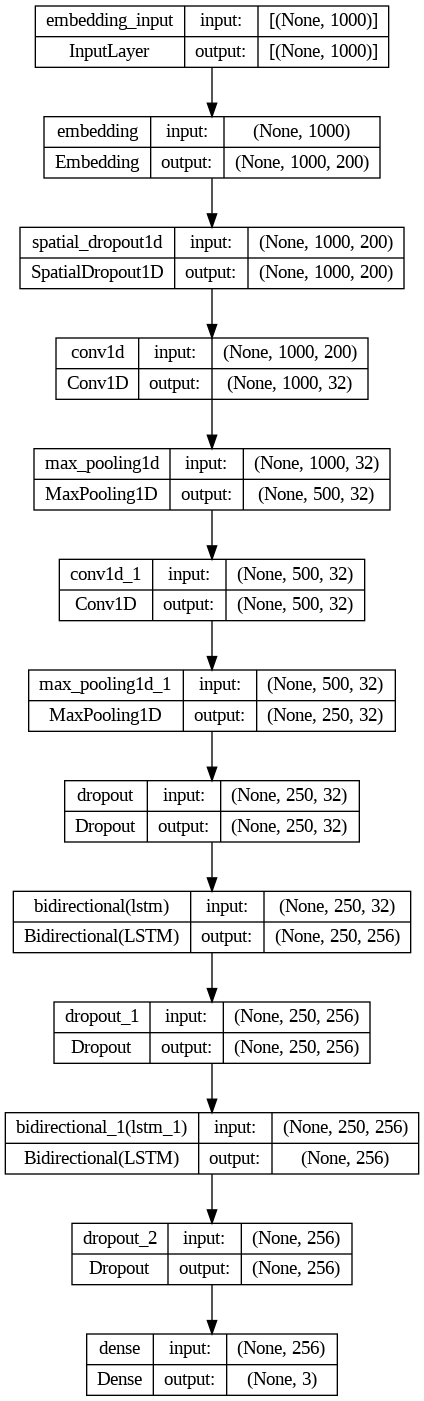

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from time import time
t1 = time()

batch_size = 256
epochs = 70

print(X_test_pad.shape)
print(y_test.shape)

print(X_train_pad.shape)
print(y_train.shape)

(67922, 1000)
(67922, 3)
(67922, 1000)
(67922, 3)


In [ ]:
hist = model.fit(X_train_pad, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/70
266/266 [==============================] - 67s 175ms/step - loss: 0.7868 - accuracy: 0.6166 - val_loss: 0.6612 - val_accuracy: 0.6910
Epoch 2/70
266/266 [==============================] - 47s 176ms/step - loss: 0.6755 - accuracy: 0.6867 - val_loss: 0.6128 - val_accuracy: 0.7224
Epoch 3/70
266/266 [==============================] - 56s 210ms/step - loss: 0.6518 - accuracy: 0.7023 - val_loss: 0.6121 - val_accuracy: 0.7216
Epoch 4/70
266/266 [==============================] - 57s 213ms/step - loss: 0.6364 - accuracy: 0.7106 - val_loss: 0.5823 - val_accuracy: 0.7347
Epoch 5/70
266/266 [==============================] - 57s 214ms/step - loss: 0.6222 - accuracy: 0.7182 - val_loss: 0.5738 - val_accuracy: 0.7429
Epoch 6/70
266/266 [==============================] - 57s 213ms/step - loss: 0.6165 - accuracy: 0.7204 - val_loss: 0.5725 - val_accuracy: 0.7414
Epoch 7/70
266/266 [==============================] - 49s 184ms/step - loss: 0.6097 - accuracy: 0.7238 - val_loss: 0.5578 - val_ac

In [ ]:
t2 = time()
t_delta = round(t2-t1,2)
print(t_delta)

3949.72


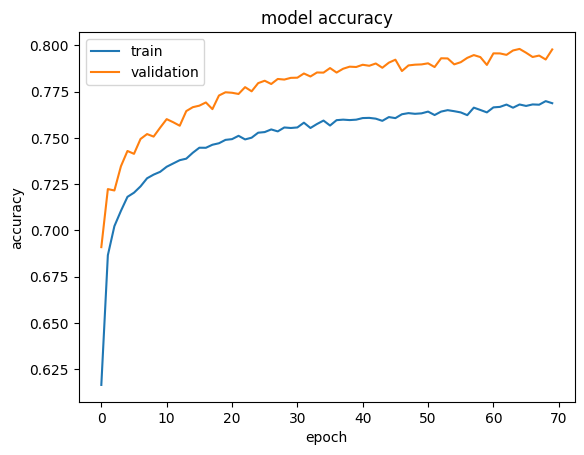

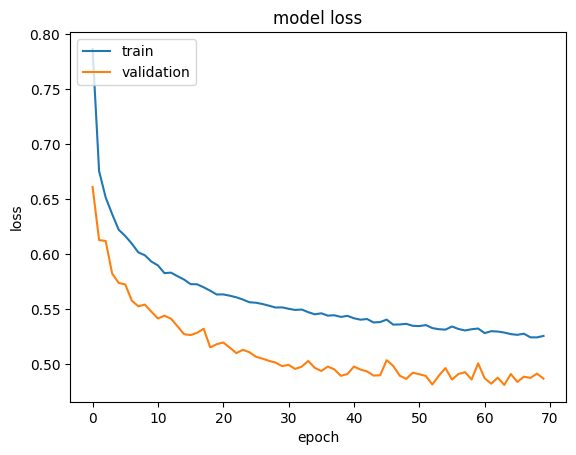

In [ ]:
# Accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

2123/2123 [==============================] - 34s 15ms/step


In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
print(precision_recall_fscore_support(data_test.Class, predictions, average='micro'))
print(precision_recall_fscore_support(data_test.Class, predictions, average='macro'))
print(precision_recall_fscore_support(data_test.Class, predictions, average='weighted'))

(0.7977680280321545, 0.7977680280321545, 0.7977680280321545, None)
(0.794535890357265, 0.7977754996177139, 0.790613788162486, None)
(0.7945404986846805, 0.7977680280321545, 0.7906137875657483, None)



F1 Score: 79.78


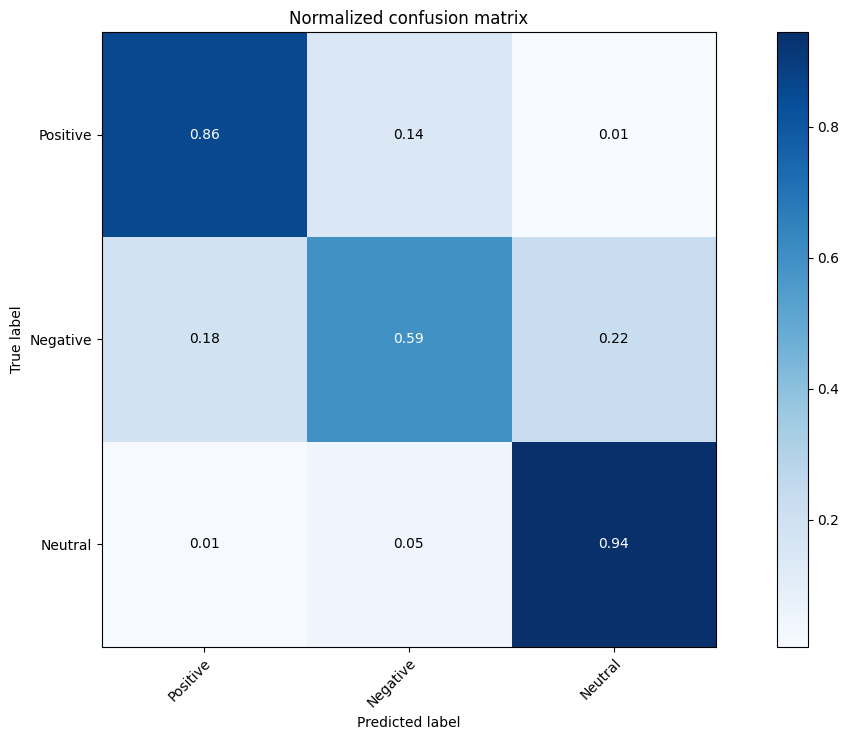

Message: Great app
Predicted: Positive


In [ ]:

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()

    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

print("\nF1 Score: {:.2f}".format(f1_score(data_test.Class, predictions, average='micro') * 100))

plot_confusion_matrix(data_test.Class, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

print('Message: {}\nPredicted: {}'.format(X_test[6], predictions[6]))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(data_test.Class, predictions)))

print('Micro Precision: {:.2f}'.format(precision_score(data_test.Class, predictions, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(data_test.Class, predictions, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(data_test.Class, predictions, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(data_test.Class, predictions, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(data_test.Class, predictions, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(data_test.Class, predictions, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(data_test.Class, predictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(data_test.Class, predictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(data_test.Class, predictions, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(data_test.Class, predictions, target_names=class_names))


Accuracy: 0.80

Micro Precision: 0.80
Micro Recall: 0.80
Micro F1-score: 0.80

Macro Precision: 0.79
Macro Recall: 0.80
Macro F1-score: 0.79

Weighted Precision: 0.79
Weighted Recall: 0.80
Weighted F1-score: 0.79

Classification Report

              precision    recall  f1-score   support

    Positive       0.82      0.86      0.84     22657
    Negative       0.76      0.59      0.67     22638
     Neutral       0.80      0.94      0.87     22627

    accuracy                           0.80     67922
   macro avg       0.79      0.80      0.79     67922
weighted avg       0.79      0.80      0.79     67922



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, log_loss, cohen_kappa_score, roc_auc_score, roc_curve
from sklearn import metrics

cm = confusion_matrix(data_test.Class, predictions)

TP = cm[0][0]
TN = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]

In [ ]:
from sklearn import metrics
print('Sensitivity : ', TP/(TP+FN))
print('Specificity : ', TN/(TN+FP))
print('false positive rate : ', FP/(FP+TN))
print('false negative rate : ', FN/(FN+TP))
print('Negative Predictive Value : ', TN/(TN+FN))
print('False Discovery rate : ', FP/(TP+FP))


Sensitivity :  0.8243823616957945
Specificity :  0.8110668597634564
false positive rate :  0.18893314023654356
false negative rate :  0.17561763830420546
Negative Predictive Value :  0.7649536167548802
False Discovery rate :  0.13904432009947598


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test,model.predict(X_test_pad)))
print('Mean Squared Error:', metrics.mean_squared_error(y_test,model.predict(X_test_pad)))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test,model.predict(X_test_pad))))
print('Cohen_Kappa_Score:', cohen_kappa_score(data_test.Class, predictions))

2123/2123 [==============================] - 34s 16ms/step
Mean Absolute Error: 0.22262137
2123/2123 [==============================] - 32s 15ms/step
Mean Squared Error: 0.09861622
2123/2123 [==============================] - 32s 15ms/step
Root Mean Squared Error: 0.3140322
Cohen_Kappa_Score: 0.6966542309728525


In [ ]:
import time

message = ['Quite often the app kicks you out and does not allow you to check in - seems to have a few bugs']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

1/1 [==============================] - 0s 108ms/step
Message: ['Quite often the app kicks you out and does not allow you to check in - seems to have a few bugs']
predicted: Neutral (0.16 seconds)


In [ ]:
import time

message = ["I still can't get this app to open. It used to work and now it tries and shuts down"]

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

1/1 [==============================] - 0s 29ms/step
Message: ["I still can't get this app to open. It used to work and now it tries and shuts down"]
predicted: Negative (0.08 seconds)


In [ ]:
import time

message = ["Always gets me where I want to go. Easy to use!"]

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

1/1 [==============================] - 0s 30ms/step
Message: ['Always gets me where I want to go. Easy to use!']
predicted: Positive (0.08 seconds)
